# Install and Import Libraries

In [12]:
# Install opencv
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
# Install visualkeras
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
import os,glob
import tensorflow as tf
import warnings
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
warnings.filterwarnings('ignore')

print(tf.__version__)

2.12.0


## Pipeline TensorFlow
We will create a dataset pipeline from our data using TensorFlow dataset API.

TensorFlow has a dataset API that supports writing descriptive and efficient input pipelines. A standard pattern is to:
- To create a source dataset from our input dataset.
- Iteration process over the dataset and processing the elements of the dataset.
- Apply transformations of a dataset to preprocess the data.

[For more information about tensorflow](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

# Load Dataset From Kaggle

In [4]:
# Install kaggle so that we can upload datasets from kaggle
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Upload the downloaded Kaggle API key file

'''Get our Kaggle API key file. To do this, follow these steps:
1. Go to the Kaggle page and click on the profile icon at the top right.
2. Select "Account" from the dropdown menu.
3. Scroll down to the "API" section and click "Create New API Token".
4. A JSON file named kaggle.json will be downloaded to our computer.'''

from google.colab import files
files.upload()

In [16]:
# Move the Kaggle API key file to the .kaggle directory
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [17]:
# Grant access permission for the Kaggle API key file
!chmod 600 ~/.kaggle/kaggle.json

In [18]:
# Download datasets from Kaggle
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

 99% 729M/736M [00:09<00:00, 78.0MB/s]
100% 736M/736M [00:09<00:00, 82.4MB/s]


# Original Dataset Information

In [ ]:
import shutil

# Ekstract zip file
shutil.unpack_archive('eye-diseases-classification.zip')

# Path to the extracted dataset directory
dataset_dir = 'dataset'

# Create a dataset object
data = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=64,
    image_size=(224, 224),
    shuffle=True,
    seed=2022
)

Found 4217 files belonging to 4 classes.


In [ ]:
os.listdir(dataset_dir)

['normal', 'cataract', 'glaucoma', 'diabetic_retinopathy']

In [ ]:
# Total files in each class
class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
class_counts = {class_name: 0 for class_name in class_names}

for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    file_list = os.listdir(class_dir)
    num_files = len(file_list)
    class_counts[class_name] = num_files

for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Total Files: {count}")

Class: cataract, Total Files: 1038
Class: diabetic_retinopathy, Total Files: 1098
Class: glaucoma, Total Files: 1007
Class: normal, Total Files: 1074


In [ ]:
# Each label
class_names = data.class_names
for idx, name in enumerate(class_names):
  print(f"{idx} = {name}")

0 = cataract
1 = diabetic_retinopathy
2 = glaucoma
3 = normal


In [ ]:
glaucoma_dir = os.path.join(dataset_dir, 'glaucoma')
normal_dir = os.path.join(dataset_dir, 'normal')
diabetic_retinopathy_dir = os.path.join(dataset_dir, 'diabetic_retinopathy')
cataract_dir = os.path.join(dataset_dir, 'cataract')

In [ ]:
os.listdir(cataract_dir)

['_367_9940827.jpg',
 '_151_5293593.jpg',
 '2182_right.jpg',
 '907_left.jpg',
 '2195_left.jpg',
 '_154_1054490.jpg',
 '_51_7561724.jpg',
 '_276_1796806.jpg',
 '_70_3464173.jpg',
 '_368_8153741.jpg',
 '1102_left.jpg',
 '_306_8888195.jpg',
 '2105_left.jpg',
 '2155_left.jpg',
 '_35_3480407.jpg',
 '_101_5139882.jpg',
 'cataract_003.png',
 '_57_8463167.jpg',
 '2133_left.jpg',
 '2195_right.jpg',
 '2236_right.jpg',
 '2139_right.jpg',
 '_49_2405371.jpg',
 '625_right.jpg',
 '2130_right.jpg',
 '_9_1244013.jpg',
 '_311_3993772.jpg',
 '_82_1805923.jpg',
 '2107_left.jpg',
 '_44_6970984.jpg',
 '_183_2695432.jpg',
 '_396_4783302.jpg',
 '_228_4231065.jpg',
 '_138_1949117.jpg',
 'cataract_037.png',
 '2129_right.jpg',
 '_282_3503490.jpg',
 '_245_5686342.jpg',
 '2151_right.jpg',
 '_50_3163122.jpg',
 '_165_8028203.jpg',
 '_193_6483689.jpg',
 '874_left.jpg',
 '_176_2398738.jpg',
 '_207_6945490.jpg',
 'cataract_062.png',
 '2104_left.jpg',
 '2158_right.jpg',
 '1062_right.jpg',
 '_254_9630074.jpg',
 '1968_lef

In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
batch[0].shape

(64, 224, 224, 3)

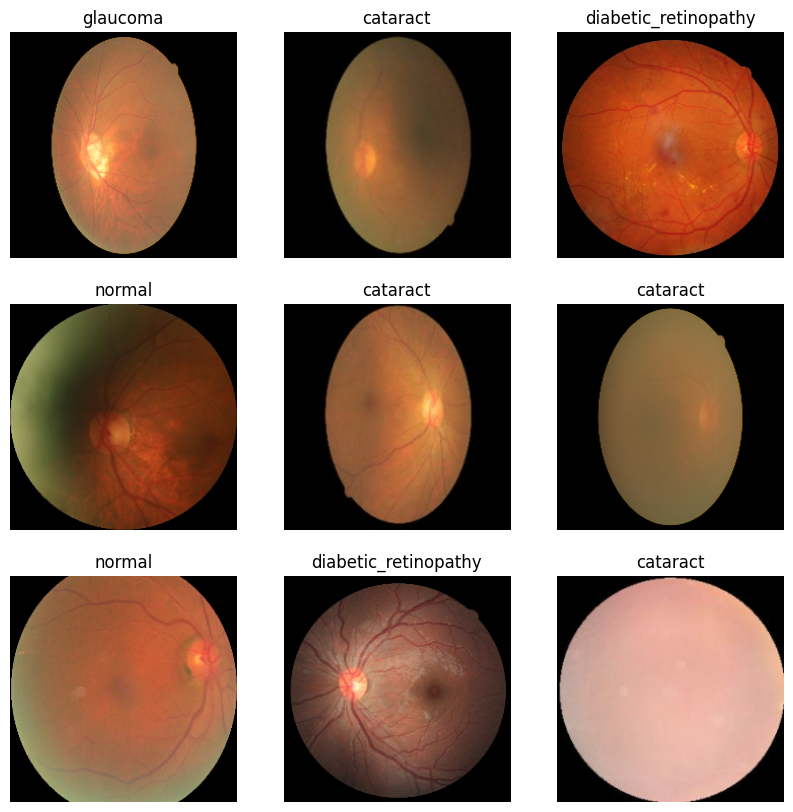

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_index = np.argmax(labels[i])
        plt.title(class_names[class_index])
        plt.axis("off")

The goal of this project is to detect cataracts early by collecting cataract and non-cataract data.

# Exploratory Data Analysis

In [ ]:
import zipfile

zip_path = 'eye-diseases-classification.zip'  # Path to the zip file
extract_dir = 'eye-diseases-classification'  # Directory to extract the contents

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction completed.")

Extraction completed.


In [ ]:
# See the file inside folder cataract
directory_catr = 'eye-diseases-classification/dataset/cataract'
file_list = os.listdir(directory_catr)
print(file_list)

['_367_9940827.jpg', '_151_5293593.jpg', '2182_right.jpg', '907_left.jpg', '2195_left.jpg', '_154_1054490.jpg', '_51_7561724.jpg', '_276_1796806.jpg', '_70_3464173.jpg', '_368_8153741.jpg', '1102_left.jpg', '_306_8888195.jpg', '2105_left.jpg', '2155_left.jpg', '_35_3480407.jpg', '_101_5139882.jpg', 'cataract_003.png', '_57_8463167.jpg', '2133_left.jpg', '2195_right.jpg', '2236_right.jpg', '2139_right.jpg', '_49_2405371.jpg', '625_right.jpg', '2130_right.jpg', '_9_1244013.jpg', '_311_3993772.jpg', '_82_1805923.jpg', '2107_left.jpg', '_44_6970984.jpg', '_183_2695432.jpg', '_396_4783302.jpg', '_228_4231065.jpg', '_138_1949117.jpg', 'cataract_037.png', '2129_right.jpg', '_282_3503490.jpg', '_245_5686342.jpg', '2151_right.jpg', '_50_3163122.jpg', '_165_8028203.jpg', '_193_6483689.jpg', '874_left.jpg', '_176_2398738.jpg', '_207_6945490.jpg', 'cataract_062.png', '2104_left.jpg', '2158_right.jpg', '1062_right.jpg', '_254_9630074.jpg', '1968_left.jpg', '_159_1399279.jpg', '_66_9729796.jpg', '21

In [ ]:
# Is the image format valid for cataract dataset?
directory_catr = 'eye-diseases-classification/dataset/cataract'
allowed_formats = ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

for filename in os.listdir(directory_catr):
    if filename.lower().endswith(allowed_formats):
        print(f"File {filename} is a valid image format.")
    else:
        print(f"File {filename} has an invalid image format.")

File _367_9940827.jpg is a valid image format.
File _151_5293593.jpg is a valid image format.
File 2182_right.jpg is a valid image format.
File 907_left.jpg is a valid image format.
File 2195_left.jpg is a valid image format.
File _154_1054490.jpg is a valid image format.
File _51_7561724.jpg is a valid image format.
File _276_1796806.jpg is a valid image format.
File _70_3464173.jpg is a valid image format.
File _368_8153741.jpg is a valid image format.
File 1102_left.jpg is a valid image format.
File _306_8888195.jpg is a valid image format.
File 2105_left.jpg is a valid image format.
File 2155_left.jpg is a valid image format.
File _35_3480407.jpg is a valid image format.
File _101_5139882.jpg is a valid image format.
File cataract_003.png is a valid image format.
File _57_8463167.jpg is a valid image format.
File 2133_left.jpg is a valid image format.
File 2195_right.jpg is a valid image format.
File 2236_right.jpg is a valid image format.
File 2139_right.jpg is a valid image forma

In [ ]:
catr_files = sorted(glob.glob('eye-diseases-classification/dataset/cataract/*.jpg'))
catr_files_png = sorted(glob.glob('eye-diseases-classification/dataset/cataract/*.png'))

catr_png = [cv2.imread(file) for file in catr_files_png]
catr = [cv2.imread(file) for file in catr_files]

In [ ]:
catr = catr + catr_png
catr

[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 

In [ ]:
# See the file inside folder normal
directory_norm = 'eye-diseases-classification/dataset/normal'
file_list = os.listdir(directory_norm)
print(file_list)

['2565_right.jpg', '3317_left.jpg', '2777_left.jpg', '3297_right.jpg', '3004_left.jpg', '2775_right.jpg', '3208_right.jpg', '2580_right.jpg', '2657_right.jpg', '2609_right.jpg', '2857_right.jpg', '3175_left.jpg', '3397_left.jpg', '939_right.jpg', '3306_right.jpg', '3079_right.jpg', '2649_right.jpg', '3425_right.jpg', '2355_right.jpg', '3042_left.jpg', '3150_left.jpg', '2356_right.jpg', '2403_left.jpg', '2718_right.jpg', '3417_left.jpg', '2826_left.jpg', '2617_left.jpg', '3390_left.jpg', '3085_right.jpg', '2988_left.jpg', '3026_right.jpg', '2827_right.jpg', '2363_left.jpg', '3399_left.jpg', '2389_left.jpg', '2463_right.jpg', '2985_left.jpg', '2351_right.jpg', '2742_right.jpg', '2399_left.jpg', '3289_left.jpg', '3064_left.jpg', '2599_right.jpg', '3016_left.jpg', '2988_right.jpg', '3083_right.jpg', '2538_right.jpg', '2662_right.jpg', '2709_right.jpg', '2368_left.jpg', '2443_left.jpg', '2685_right.jpg', '3377_left.jpg', '1253_right.jpg', '3295_right.jpg', '3069_right.jpg', '3356_left.jpg',

In [ ]:
# Is the image format valid for normal dataset?
directory_norm = 'eye-diseases-classification/dataset/normal'
allowed_formats = ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

for filename in os.listdir(directory_norm):
    if filename.lower().endswith(allowed_formats):
        print(f"File {filename} is a valid image format.")
    else:
        print(f"File {filename} has an invalid image format.")

File 2565_right.jpg is a valid image format.
File 3317_left.jpg is a valid image format.
File 2777_left.jpg is a valid image format.
File 3297_right.jpg is a valid image format.
File 3004_left.jpg is a valid image format.
File 2775_right.jpg is a valid image format.
File 3208_right.jpg is a valid image format.
File 2580_right.jpg is a valid image format.
File 2657_right.jpg is a valid image format.
File 2609_right.jpg is a valid image format.
File 2857_right.jpg is a valid image format.
File 3175_left.jpg is a valid image format.
File 3397_left.jpg is a valid image format.
File 939_right.jpg is a valid image format.
File 3306_right.jpg is a valid image format.
File 3079_right.jpg is a valid image format.
File 2649_right.jpg is a valid image format.
File 3425_right.jpg is a valid image format.
File 2355_right.jpg is a valid image format.
File 3042_left.jpg is a valid image format.
File 3150_left.jpg is a valid image format.
File 2356_right.jpg is a valid image format.
File 2403_left.jpg

In [ ]:
norm_files = sorted(glob.glob('eye-diseases-classification/dataset/normal/*.jpg'))
norm_files_png = sorted(glob.glob('eye-diseases-classification/dataset/normal/*.png'))

norm_png = [cv2.imread(file) for file in norm_files_png]
norm = [cv2.imread(file) for file in norm_files]

In [ ]:
norm = norm + norm_png
norm

[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 

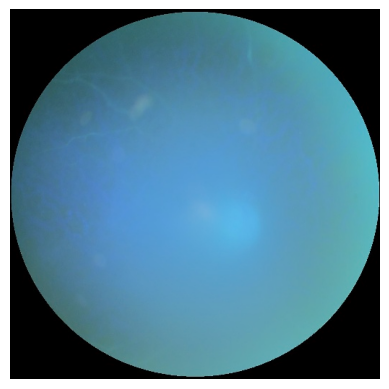

In [ ]:
def imshow(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

imshow(catr[100])

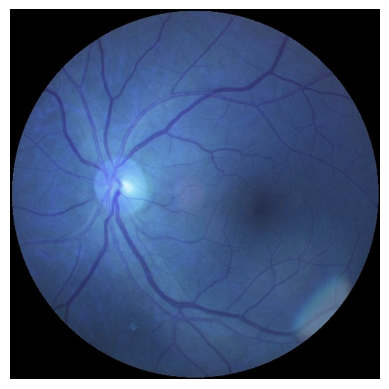

In [ ]:
def imshow(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

imshow(norm[0])

In [ ]:
# If open in Jupyter Notebook, use the code below.
'''
def cv2_imshow(image):
    cv2.imshow('Image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
cv2_imshow(catr[100])
'''

"\ndef cv2_imshow(image):\n    cv2.imshow('Image', image)\n    cv2.waitKey(0)\n    cv2.destroyAllWindows()\ncv2_imshow(catr[100])\n"

Insights from the exploratory data analysis:

1. File List: The code displays the list of files present in the 'cataract' and 'normal' directories. It helps in verifying the file names and their availability.

2. Image Format Validation: The code checks if the image files in the 'cataract' and 'normal' directories have valid image formats. It ensures that only files with formats like '.bmp', '.gif', '.jpeg', '.jpg', and '.png' are considered as valid image files.

3. Loading Images: The code loads the images from the 'cataract' and 'normal' directories using OpenCV. It reads the image files, and the resulting images are stored in the 'catr' and 'norm' variables, respectively.

4. Displaying Images: The code defines a function called 'imshow' to display the images. It uses Matplotlib to show the images without axes. The images from the 'catr' and 'norm' variables are displayed using this function.

Overall, the provided code helps in examining the file list, validating the image formats, loading the images, and visualizing the images from the 'cataract' and 'normal' datasets.

In [ ]:
# Generating dataset from directory -> preparation import dataset for TensorFlow modelling

data = tf.keras.utils.image_dataset_from_directory(directory = 'eye-diseases-classification/dataset',
                                                   color_mode = 'rgb',
                                                   batch_size = 64,
                                                   image_size = (224,224),
                                                   shuffle=True,
                                                   seed = 2022)

Found 4217 files belonging to 4 classes.


In [ ]:
# Path to the original dataset directory
dataset_dir = 'dataset'  # Replace with the path to our dataset directory

# Path to the target directory
cataract_dir = os.path.join(dataset_dir, 'cataract')
normal_dir = os.path.join(dataset_dir, 'normal')

# Remove the directories of the non-cataract classes
for class_name in ['diabetic_retinopathy', 'glaucoma']:
    class_dir = os.path.join(dataset_dir, class_name)
    shutil.rmtree(class_dir)

# Count the number of files in the cataract and normal classes
cataract_count = len(os.listdir(os.path.join(dataset_dir, 'cataract')))
normal_count = len(os.listdir(os.path.join(dataset_dir, 'normal')))
print(f"Total files in cataract class: {cataract_count}")
print(f"Total files in normal class: {normal_count}")

Total files in cataract class: 1038
Total files in normal class: 1074


In [ ]:
# Generating dataset
data = tf.keras.utils.image_dataset_from_directory(directory = dataset_dir,
                                                   color_mode = 'rgb',
                                                   batch_size = 64,
                                                   image_size = (224,224),
                                                   shuffle=True,
                                                   seed = 2022)

Found 2112 files belonging to 2 classes.


## Distribution Image

In [ ]:
labels = np.concatenate([y for x,y in data], axis=0)

In [ ]:
data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
labels_filtered = np.array(labels)
labels_filtered = np.where(labels == 3, 1, 0)
labels_filtered

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
values = pd.value_counts(labels)
values = values.sort_index()
values

0    1038
1    1074
dtype: int64

In [ ]:
class_names = data.class_names
for idx, name in enumerate(class_names):
  print(f"{idx} = {name}")

0 = cataract
1 = normal


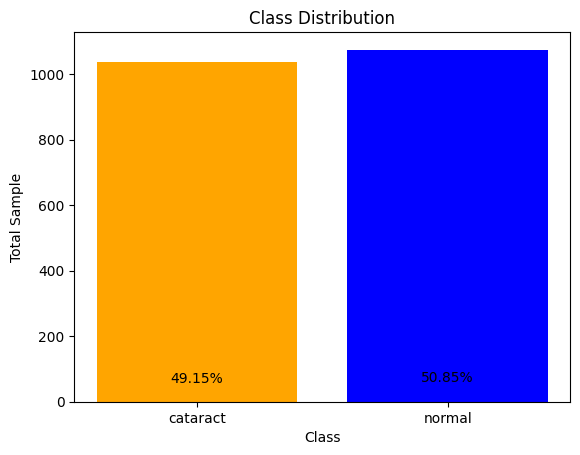

In [ ]:
# Calculate the percentage of each class
total_samples = len(labels_filtered)
class_percentages = [(count / total_samples) * 100 for count in values]

# Bar chart
plt.bar(class_names, values, color=['orange' if class_name == 'cataract' else 'blue' for class_name in class_names])
plt.xlabel('Class')
plt.ylabel('Total Sample')
plt.title('Class Distribution')

# Add percentage labels on top of each bar
for i, percentage in enumerate(class_percentages):
    plt.text(i, percentage, f'{percentage:.2f}%', ha='center', va='bottom')

# Show the plot
plt.show()

## Generate to Explore The Dataset/EDA

In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [ ]:
data_iterator

In [ ]:
batch[0].shape

(64, 224, 224, 3)

batch[0].shape produces output (64, 224, 224, 3). This means batch[0] is the image input in batch form, with dimensions (64, 224, 224, 3).


>


     64 is the batch size, i.e. the number of images in the batch.
     224 and 224 are the spatial dimensions of each image, which indicates that each image has a resolution of 224x224 pixels.
     3 is the number of color channels, indicating that the image uses an RGB color scheme with three channels (red, green, blue).

In [ ]:
batch[1].shape

(64,)

batch[1].shape produces output (64,). This means batch[1] is the label for each image in the batch, with dimension (64,).


>

     64 is the batch size, indicating that there are 64 labels in the batch.

Thus, batch[0] is an array of image inputs of shape (64, 224, 224, 3) and batch[1] is an array of labels of shape (64,).

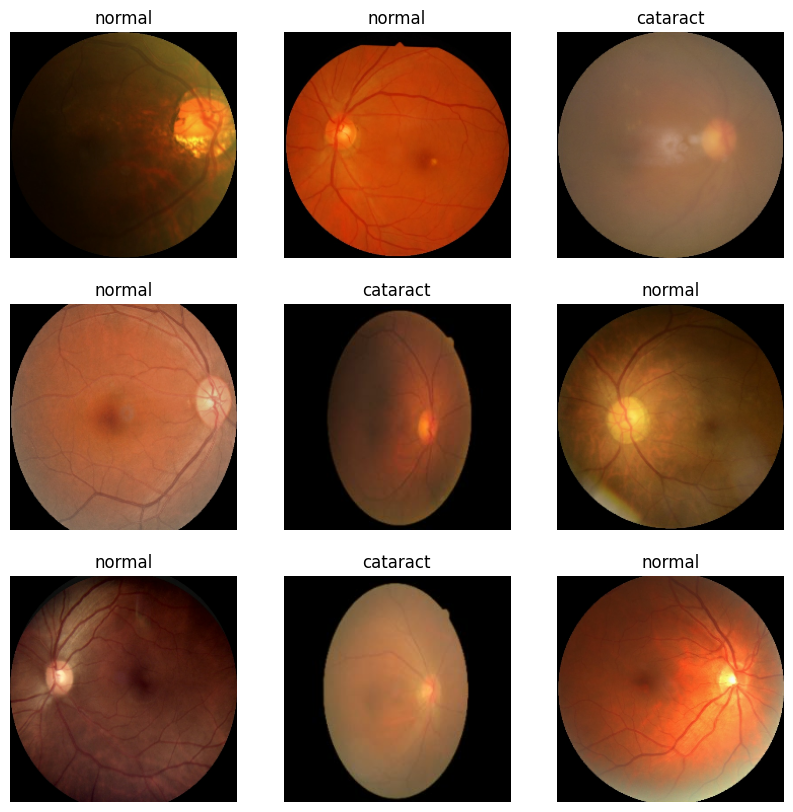

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Standardization Dataset

In [ ]:
data = data.map(lambda x, y: (x/255, y))

The division operation x (image input) is performed by 255. <br>
This is done as a normalization step in the image. Normalization is the process of changing the range of pixel values in an image to a smaller or normal range. In this case, the original pixel values in the image are in the range 0-255 for each color (RGB) channel. <br>
By dividing the image by 255, we change the pixel value range to 0-1.

In [ ]:
sample = data.as_numpy_iterator().next()

# Print min and max value
print('minimum value: ',sample[0].min())
print('maximum value: ',sample[0].max())

minimum value:  0.0
maximum value:  1.0


In [ ]:
sample

(array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [

In the given code sample = `data.as_numpy_iterator().next()`, first of all, the dataset object is converted into an iterator using the `as_numpy_iterator()` method. Then, the `.next()` method is called on the iterator to retrieve the first batch of data and store it in the sample variable.

Then, in the code `print('minimum value: ',sample[0].min())`, we print the minimum value of the image elements in the first batch using the `.min()` method. This threshold will reflect the lowest pixel value in the batch of images.

Next, in the code `print('maximum value: ',sample[0].max())`, we print the maximum value of the image elements in the first batch using the `.max()` method. This maximum value will reflect the highest pixel value in the batch of images.

By printing the minimum and maximum values, we can check the range of pixel values in a batch of images. This can be helpful in ensuring that data is normalized or scaled correctly before feeding images into models or algorithms that require a certain range of values.

## Splitting

In [ ]:
print("Total number of batchs = ",len(data))

Total number of batchs =  33


In [ ]:
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))
train_size = int(0.7 * len(data)) +1

We divide the dataset into three different subsets: the train set, the validation set, and the test set, with the respective proportions of 70%, 20%, and 10% of the entire dataset.

- `val_size = int(0.2 * len(data))` <br>
The variable val_size determines the size of the validation set. In this example, the validation set size is calculated as 20% of the entire dataset, using the len(data) function to get the total number of samples in the dataset.

- `test_size = int(0.1 * len(data))` <br>
The test_size variable determines the size of the test set. In this example, the size of the test set is calculated as 10% of the entire dataset.

- `train_size = int(0.7 * len(data)) + 1` <br>
The train_size variable determines the size of the train set. In this example, the size of the train set is calculated as 70% of the entire dataset plus 1. This is done by converting the product to an integer and adding 1 to ensure that the size of the train set does not lose to 70% of the dataset.

In [ ]:
train_size

24

In [ ]:
# Handling data leakage
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

- `train = data.take(train_size)` <br>
A subset of the train set is generated by using the take() method on the dataset data object. This method takes a number of samples (according to train_size) from the start of the dataset.

- `remaining = data.skip(train_size)` <br>
The remaining subset of data (data not yet fetched for the train set) is generated using the skip() method on the data dataset object. This method ignores the number of samples (according to train_size) from the start of the dataset.

- `val = remaining.take(val_size)` <br>
A subset of the validation set is generated using the take() method on the remaining dataset object. This method takes a number of samples (according to val_size) from the initial subset of the rest of the data.

- `test = remaining.skip(val_size)` <br>
A subset of the test set is generated using the skip() method on the remaining dataset object. This method ignores the number of samples (according to val_size) from the initial subset of the rest of the data.

After executing this code, the variables train, val, and test will each contain one of the subsets of the train set, validation set, and test set that we divided according to the specified proportion.

In [ ]:
print(f"# train batchs = {len(train)}, # validate batchs = {len(val)}, # test batch = {len(test)}")
len(train) + len(val) + len(test)

# train batchs = 24, # validate batchs = 6, # test batch = 3


33

## Preparation Image Dataset Test

In [ ]:
test_iter = test.as_numpy_iterator()

The code `test_iter = test.as_numpy_iterator()`, the test dataset object is converted to an iterator using the `.as_numpy_iterator()` method. It allows us to access data in batch form sequentially.

After that, we can use the `test_iter` iterator to access batches of test data sequentially by using the `.next()` method.

In [ ]:
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
  try:
    batch = test_iter.next()
    test_set['images'] = np.concatenate((test_set['images'], batch[0]))
    test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
  except:
    break

In [ ]:
y_true = test_set['labels']

The dictionary `test_set` has two keys: "images" and "labels".  The initial value of "images" is an empty array with shape (0, 224, 224, 3) which will be used to store images, and the initial value of "labels" is an empty array with shape (0) which will be used to store labels.

Next, we use the while True loop to iteratively fetch the batch from the `test_iter` iterator using the `.next()` method and add it to test_set['images'] and test_set['labels'].


- `batch = test_iter.next()` <br>
Takes the next batch from the test_iter iterator and stores it in the batch variable.

- `test_set['images'] = np.concatenate((test_set['images'], batch[0]))` <br>
Combines a batch of images (batch[0]) with an existing array of images (test_set['images']) using np.concatenate() function. The combined results are stored back into test_set['images'].

- `test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))` <br>
Merges a batch of labels (batch[1]) with an existing array of labels (test_set['labels']) using np.concatenate() function. The combined results are stored back into test_set['labels'].

An exception (except) will occur when the iteration exceeds the number of batches in the test_iter iterator. At that point, the program will exit the while True loop by using the break statement.

With the code above, we collect all batches of images and labels from the test dataset into `test_set['images']` and `test_set['labels']`.


In [ ]:
test_set

{'images': array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 

In [ ]:
test_set['labels']

array([1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

## CNN -> Model Baseline

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

In [ ]:
# Displaying history loss/accuracy
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def historical_plot(history):
    plt.figure(figsize=(15,12))
    metrics = ['accuracy', 'loss']
    for i, metric in enumerate(metrics):
        plt.subplot(220+1+i)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
    plt.show()

`historical_plot()` function is used to draw graphs to see changes in loss and accuracy during model training.

In [ ]:
def model_baselineCNN():
    model = Sequential([
        Conv2D(filters = 64, kernel_size=3, activation = 'relu',padding='same', input_shape=(224,224,3)),
        Conv2D(filters = 64, kernel_size=3, activation = 'relu',padding='same'),
        BatchNormalization(),
        MaxPool2D(2),
        Dropout(0.3),

        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        BatchNormalization(),
        MaxPool2D(2),
        Dropout(0.3),

        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        BatchNormalization(),
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        BatchNormalization(),
        MaxPool2D(2),
        Dropout(0.3),

        Flatten(),
        Dense(64, activation = 'relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(128, activation = 'relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(4, activation='softmax')
    ])
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
    return model

The `model_baselineCNN()` function is an implementation of the Convolutional Neural Network (CNN) model with a specific architecture.

In [ ]:
model = model_baselineCNN()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     7

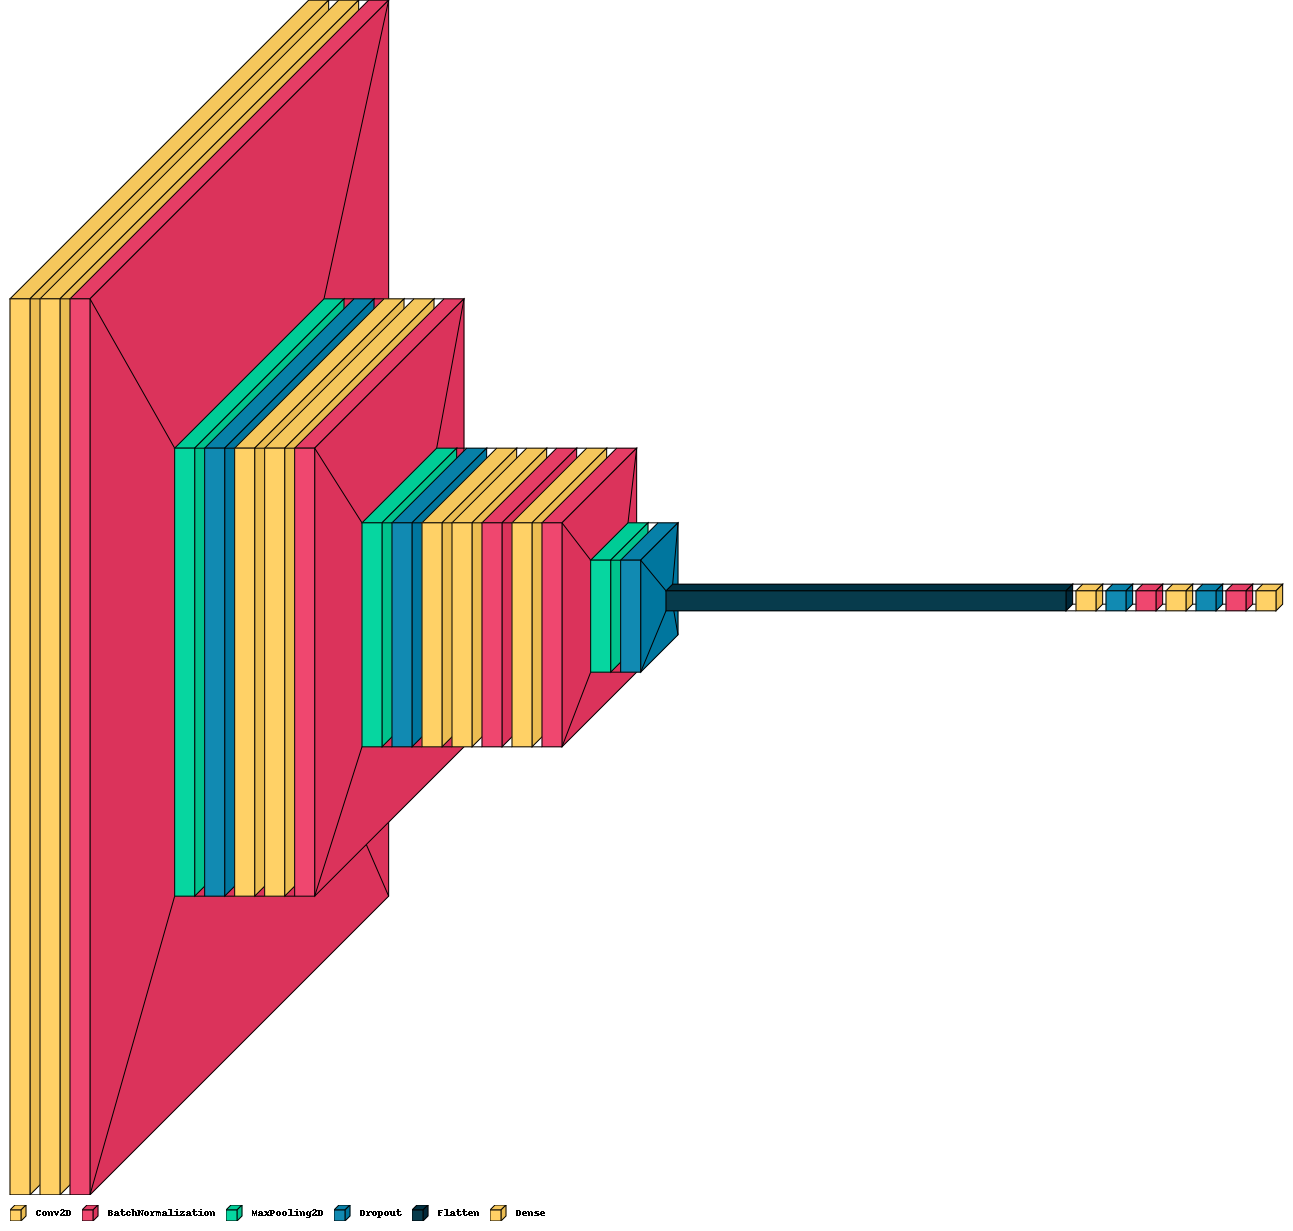

In [ ]:
model.summary()

visualkeras.layered_view(model,legend=True)

In [ ]:
%%time

from keras import callbacks
# Stopping if there is not improvement, if the accuracy didn't improve much for 10 epochs
early_stop = callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        verbose=1,
        mode="max",
        restore_best_weights=True,
     )

history = model.fit(
    train,
    validation_data=val,
    epochs = 30,
    callbacks=[early_stop],
)

Epoch 1/30
24/24 [==============================] - 1095s 45s/step - loss: 1.3413 - accuracy: 0.5039 - val_loss: 1.2387 - val_accuracy: 0.4792
Epoch 2/30
24/24 [==============================] - 1104s 46s/step - loss: 1.0680 - accuracy: 0.6296 - val_loss: 1.1316 - val_accuracy: 0.5807
Epoch 3/30
24/24 [==============================] - 1103s 46s/step - loss: 0.9230 - accuracy: 0.6855 - val_loss: 1.0536 - val_accuracy: 0.6250
Epoch 4/30
24/24 [==============================] - 1089s 45s/step - loss: 0.7828 - accuracy: 0.7350 - val_loss: 1.4510 - val_accuracy: 0.4896
Epoch 5/30
24/24 [==============================] - 1085s 45s/step - loss: 0.7951 - accuracy: 0.7038 - val_loss: 4.6474 - val_accuracy: 0.3776
Epoch 6/30
24/24 [==============================] - 1080s 45s/step - loss: 0.6302 - accuracy: 0.7559 - val_loss: 7.9494 - val_accuracy: 0.0260
Epoch 7/30
24/24 [==============================] - 1083s 45s/step - loss: 0.6077 - accuracy: 0.7663 - val_loss: 10.7287 - val_accuracy: 0.002

### Evaluate The Model Data Test

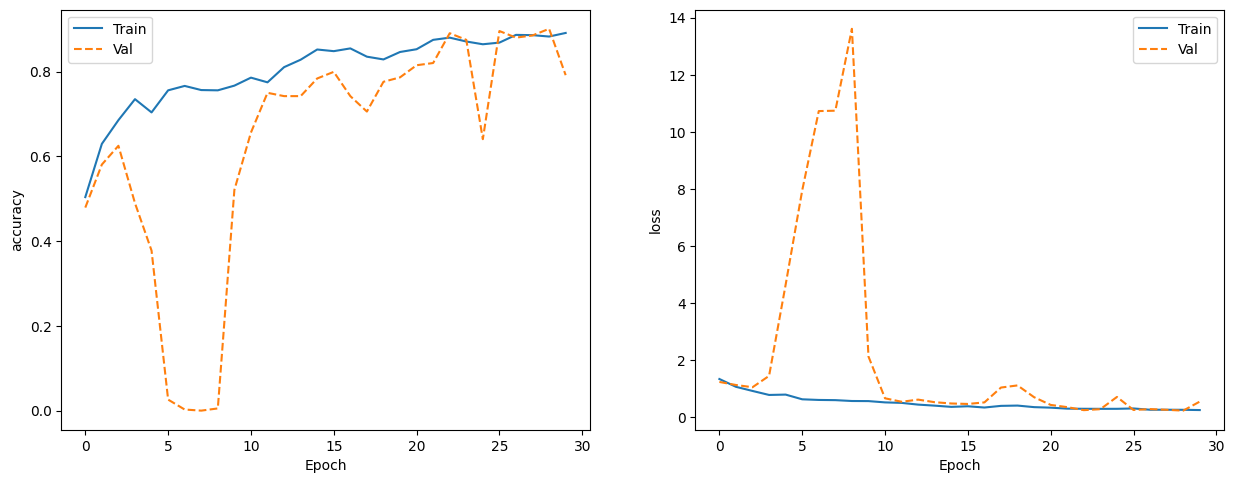

In [ ]:
historical_plot(history)

In [ ]:
y_pred = np.argmax(model.predict(test_set['images']), 1)

6/6 [==============================] - 33s 6s/step


In [ ]:
print(classification_report(y_true, y_pred, target_names = class_names))

              precision    recall  f1-score   support

    cataract       1.00      0.51      0.68        92
      normal       0.69      1.00      0.82       100

    accuracy                           0.77       192
   macro avg       0.84      0.76      0.75       192
weighted avg       0.84      0.77      0.75       192



Text(0.5, 1.0, 'Confusion Matrix')

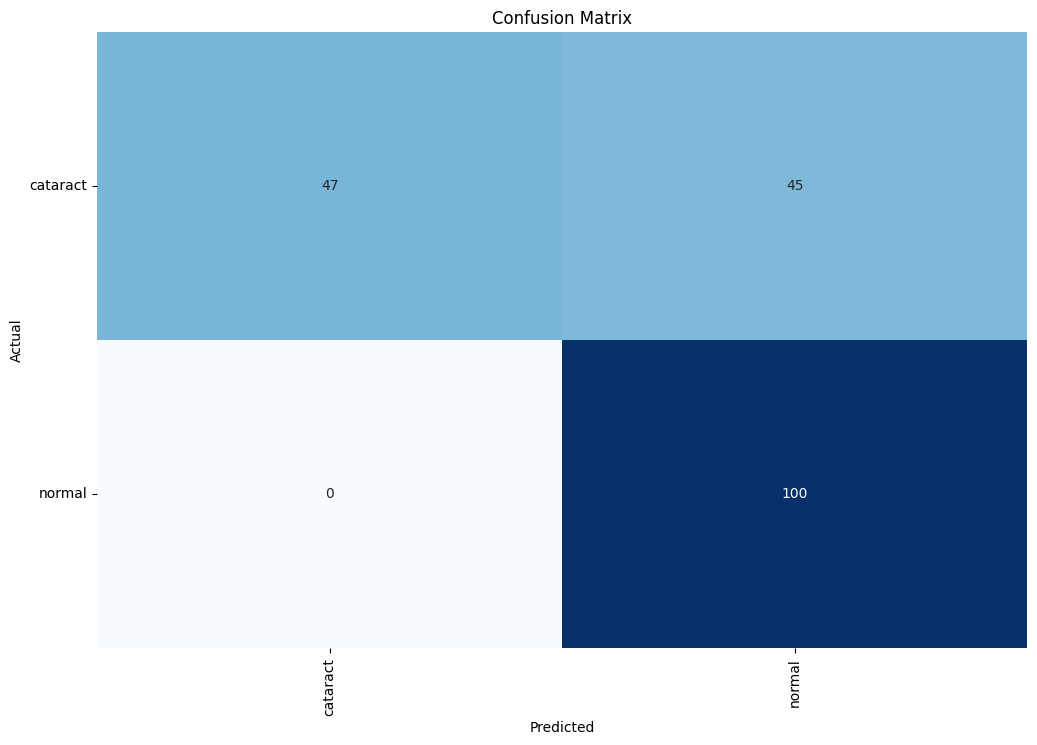

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(2)+.5, class_names, rotation=90) #arange(number_class)+.5
plt.yticks(np.arange(2)+.5, class_names, rotation=0) #arange(number_class)+.5
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

## Transfer Learning -> Model Improvement
[Read more about transfer learning here](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
def resnet_tl():
    effnet = ResNet50(include_top=False, weights="imagenet",input_shape=(224,224,3), pooling='max')
    effnet.trainable=False

    for layer in effnet.layers[83:]:
      layer.trainable=True

    x = effnet.output
    x = BatchNormalization()(x)
    x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x = Dropout(rate=.45, seed=2022)(x)
    output=Dense(4, activation='softmax')(x)

    model= tf.keras.Model(inputs=effnet.input, outputs=output)
    model.compile(optimizer = 'adamax', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

The `resnet_tl()` function implements transfer learning using the ResNet50 model that has been trained on the ImageNet dataset.

The following is an explanation of the function:

    effnet = ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3), pooling='max'): Creates a ResNet50 model object with the following parameters:
        include_top=False: Removed the top fully-connected layer (output layer) in the ResNet50 model.
        weights="imagenet": Using pre-trained weights from the ResNet50 model that has been trained on the ImageNet dataset.
        input_shape=(224,224,3): Specifies the size of the input image expected by the model.
        pooling='max': Using max pooling layer on model output.

    effnet.trainable=False: Specifies that all layers in the ResNet50 model cannot be trained (freeze) so that they are only used for feature extraction.

    for layer in effnet.layers[83:]: layer.trainable=True: Sets the layers at index 83 onwards to be trainable. This allows the last few layers of the ResNet50 model to participate in the relearning process.

    x = effnet.output: Takes the output of the ResNet50 model.

    x = BatchNormalization()(x): Added a batch normalization layer to stabilize the distribution of values on the input.

    x = Dense(1024, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006), activation='relu')(x): Added a Dense layer with 1024 units, used L2 and L1 regularization to reduce overfitting, and activated ReLU.

    x = Dropout(rate=.45, seed=2022)(x): Added a Dropout layer to prevent overfitting by randomly ignoring some units during training.

    output = Dense(4, activation='softmax')(x): Added an output layer with 4 units and used the softmax activation function for multi-class classification.

    model = tf.keras.Model(inputs=effnet.input, outputs=output): Create a model by connecting the input of the ResNet50 model (effnet.input) to a predefined output (output).

    model.compile(optimizer='adamax', loss='sparse_categorical_crossentropy', metrics=['accuracy']): Compiles the model using the Adamax optimizer, the loss function sparse_categorical_crossentropy (because the label is an integer), and the accuracy evaluation metric.

    return model: Returns the generated model object.

In [ ]:
model_tl = resnet_tl()

94765736/94765736 [==============================] - 1s 0us/step


### Training TL Model ResNet

In [ ]:
%%time
from keras import callbacks
early_stop = callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        verbose=1,
        mode="max",
        restore_best_weights=True,
     )

history = model_tl.fit(
    train,
    validation_data=val,
    epochs = 30,
    callbacks=[early_stop],
)

Epoch 1/30
24/24 [==============================] - 576s 24s/step - loss: 22.9913 - accuracy: 0.6426 - val_loss: 44.2442 - val_accuracy: 0.5026
Epoch 2/30
24/24 [==============================] - 558s 23s/step - loss: 18.1740 - accuracy: 0.8405 - val_loss: 48.7017 - val_accuracy: 0.5078
Epoch 3/30
24/24 [==============================] - 559s 23s/step - loss: 15.4670 - accuracy: 0.8607 - val_loss: 33.9349 - val_accuracy: 0.4948
Epoch 4/30
24/24 [==============================] - 562s 23s/step - loss: 13.2525 - accuracy: 0.9147 - val_loss: 25.7669 - val_accuracy: 0.4792
Epoch 5/30
24/24 [==============================] - 575s 24s/step - loss: 11.6099 - accuracy: 0.9095 - val_loss: 18.4835 - val_accuracy: 0.4974
Epoch 6/30
24/24 [==============================] - 557s 23s/step - loss: 10.2921 - accuracy: 0.9154 - val_loss: 22.2025 - val_accuracy: 0.4896
Epoch 7/30
24/24 [==============================] - 559s 23s/step - loss: 9.0717 - accuracy: 0.9258 - val_loss: 22.1791 - val_accuracy: 

### Evaluate the model in data test

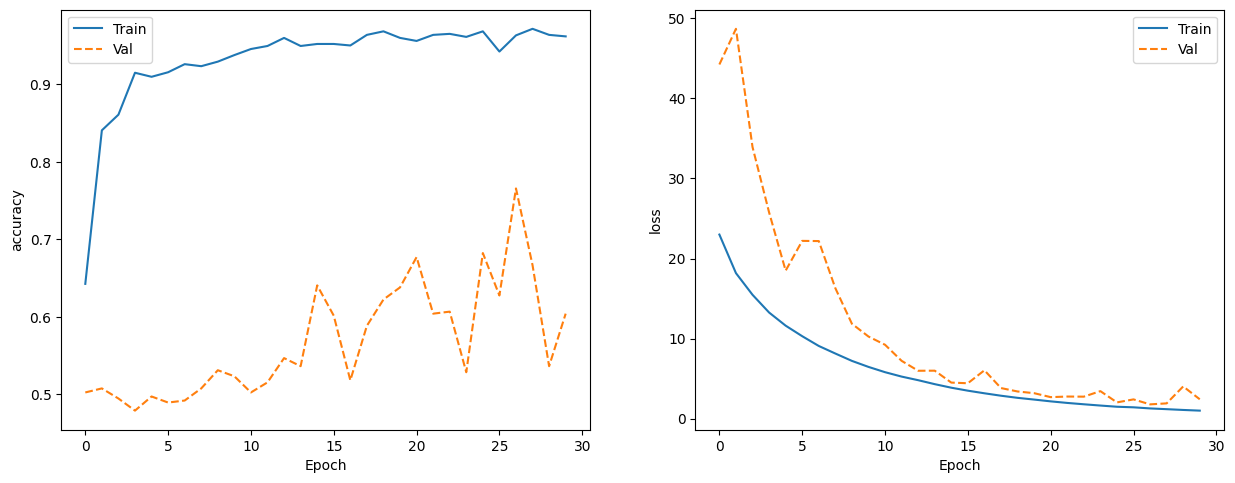

In [ ]:
historical_plot(history)

In [ ]:
y_pred = np.argmax(model_tl.predict(test_set['images']), 1)

6/6 [==============================] - 27s 4s/step


In [ ]:
print(classification_report(y_true, y_pred, target_names = class_names))

              precision    recall  f1-score   support

    cataract       1.00      0.16      0.28        92
      normal       0.56      1.00      0.72       100

    accuracy                           0.60       192
   macro avg       0.78      0.58      0.50       192
weighted avg       0.77      0.60      0.51       192



Compare with CNN -> Model Baseline      
             
              precision    recall  f1-score   support

    cataract       1.00      0.51      0.68        92
      normal       0.69      1.00      0.82       100

    accuracy                           0.77       192
    macro avg      0.84      0.76      0.75       192
    weighted avg   0.84      0.77      0.75       192

It turns out that the results from the baseline are better.


Text(0.5, 1.0, 'Confusion Matrix')

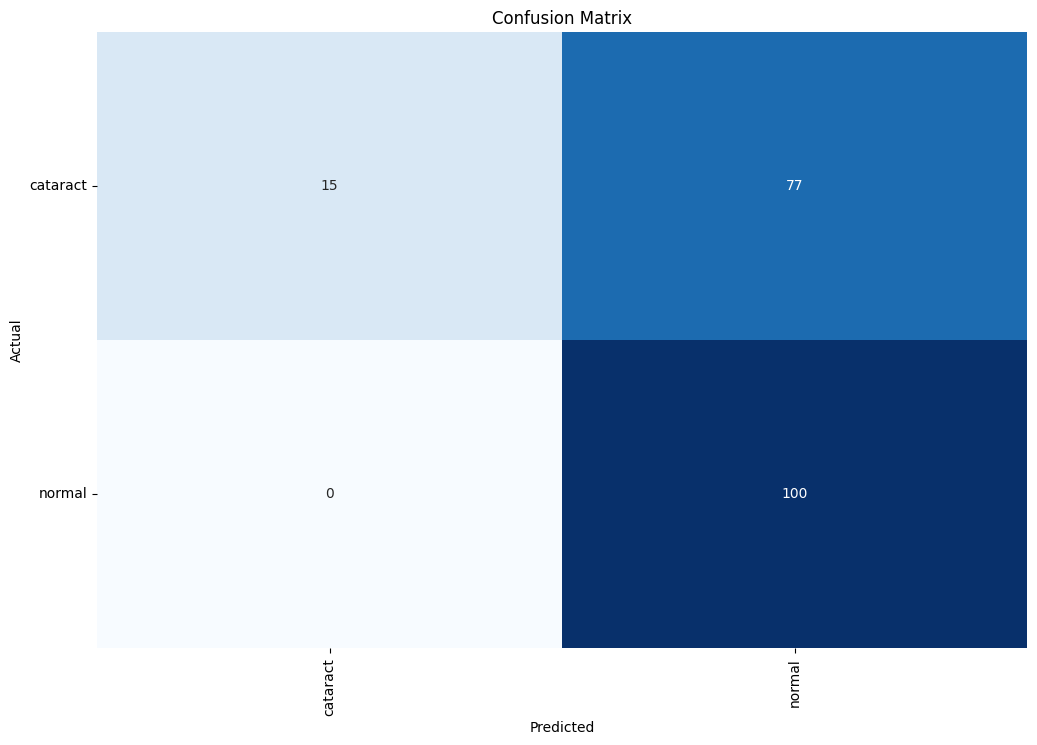

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(2)+.5, class_names, rotation=90)
plt.yticks(np.arange(2)+.5, class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")